In [1]:
# to use GPU, first check on the terminal: 
# nvcc --version 
# nvidia-smi
# then turn use GPU to True

import tifffile as tiff
import matplotlib.pyplot as plt
import os, shutil
import numpy as np

from cellpose import core, utils, io, models, metrics, plot
from glob import glob
#import pickle

use_GPU = core.use_gpu()
yn = ['NO', 'YES']
print(f'>>> GPU activated? {yn[use_GPU]}')

>>> GPU activated? YES


In [2]:
# Custom model path
model_path = "/Volumes/projects-03/Feyza/segmentation/cellpose_nuclei_membrane/training_data_05z/models/CP_20241007_h2bxncad"

# Path to images
image_dir = "/Volumes/projects-03/Feyza/240925-NcadGFPxH2Bch/20240925_151619_20240925_NcadxH2B_05z_timelapse/2d_segmentation_test"

# Channel Parameters
'''# Here we match the channel to number
if Channel_to_use_for_segmentation == "Grayscale":
  chan = 0
elif Channel_to_use_for_segmentation == "Blue":
  chan = 3
elif Channel_to_use_for_segmentation == "Green":
  chan = 2
elif Channel_to_use_for_segmentation == "Red":
  chan = 1
    
if Second_segmentation_channel == "Blue":
  chan2 = 3
elif Second_segmentation_channel == "Green":
  chan2 = 2
elif Second_segmentation_channel == "Red":
  chan2 = 1
elif Second_segmentation_channel == "None":
  chan2 = 0'''

chan = 1
chan2 = 2

# Segmentation Parameters
diameter = 25
flow_threshold = 0.8
cellprob_threshold = -1


In [4]:
# run model in a directory of multichannel image series

dir = "/Volumes/projects-03/Feyza/240925-NcadGFPxH2Bch/20240925_151619_20240925_NcadxH2B_05z_timelapse/2d_segmentation_test"
# gets image files in dir (ignoring image files ending in _masks)
files = io.get_image_files(dir, '_masks')
print(files)
images = [io.imread(f) for f in files]

# declare model
model = models.CellposeModel(gpu=False, 
                             pretrained_model=model_path)

# use model diameter if user diameter is 0
diameter = model.diam_labels if diameter==0 else diameter

# run model on test images
masks, flows, styles = model.eval(images, 
                                  channels=[chan, chan2],
                                  diameter=diameter,
                                  flow_threshold=flow_threshold,
                                  cellprob_threshold=cellprob_threshold
                                  )


ValueError: ERROR: no files in --dir folder 

In [5]:
# save output to *_seg.npy
io.masks_flows_to_seg(images, 
                      masks, 
                      flows, 
                      files, 
                      channels=[chan, chan2],
                      diams=diameter*np.ones(len(masks)), 
                      )

In [6]:
#save output masks to tiffs/pngs or txt files for imageJ
io.save_masks(images, 
              masks, 
              flows, 
              files, 
              channels=[chan, chan2],
              png=True, # save masks as PNGs and save example image
              tif=True, # save masks as TIFFs
              save_txt=True, # save txt outlines for ImageJ
              save_flows=False, # save flows as TIFFs
              save_outlines=False, # save outlines as TIFFs 
              save_mpl=True # make matplotlib fig to view (WARNING: SLOW W/ LARGE IMAGES)
              )

In [3]:
f = files[19]
plt.figure(figsize=(12,4), dpi=300)
plt.imshow(io.imread(os.path.splitext(f)[0] + '_cp_output.png'))
plt.axis('off')

NameError: name 'files' is not defined

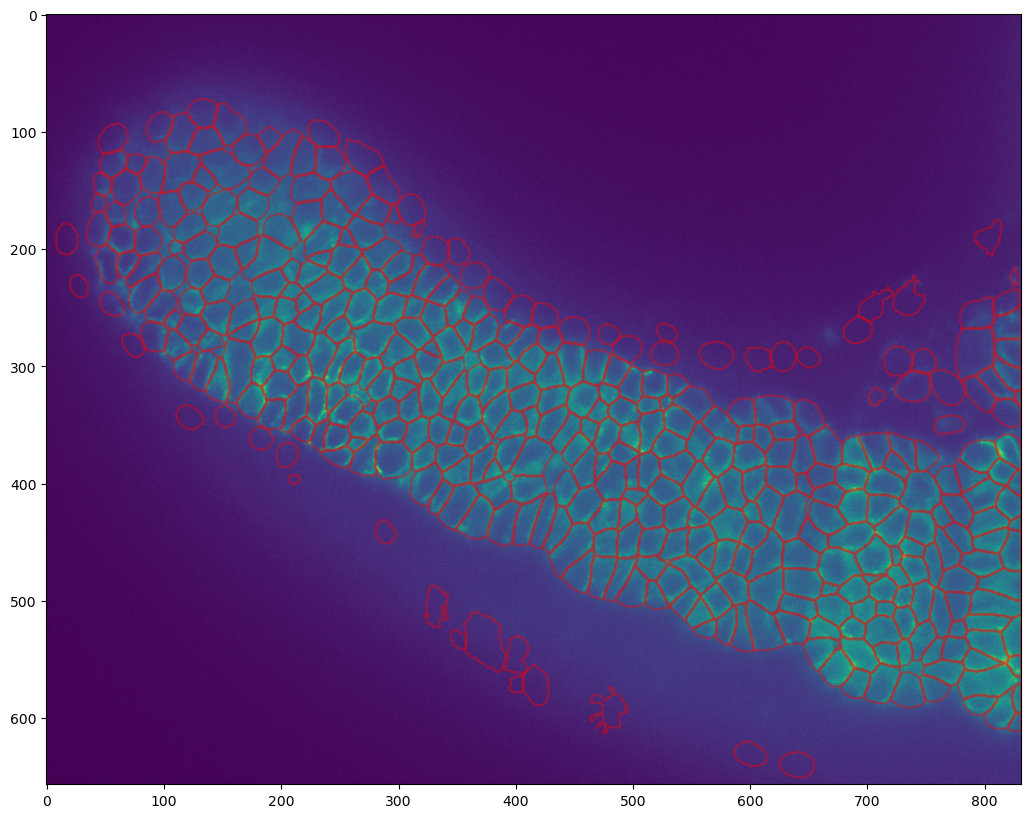

In [55]:
# sneek peak 

img_path = files[18]
img = io.imread(img_path)[0]

plt.figure(figsize=(15, 10))
dat = np.load(img_path.replace('.tif','_seg.npy'), allow_pickle=True).item()
outlines = utils.outlines_list(dat['masks'])
plt.imshow(img)
for o in outlines:
    plt.plot(o[:,0], o[:,1], color='r', alpha = 0.4)

plt.imshow(img)


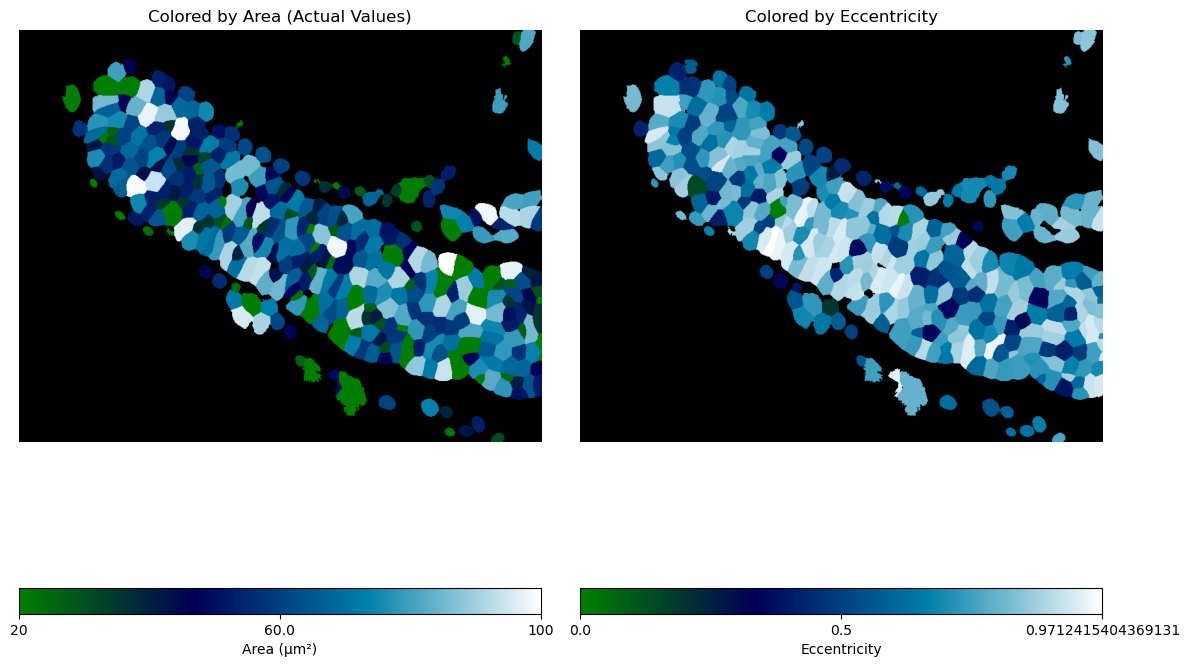

In [150]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure

def extract_mask_values_and_areas(masks, pixel_size):
    unique_values = np.unique(masks)
    areas_dict = {}
    
    for value in unique_values:
        if value != 0:  # Skip the background
            area_in_pixels = np.sum(masks == value)
            area_in_microns = area_in_pixels * (pixel_size ** 2)
            areas_dict[value] = area_in_microns
            
    return areas_dict

def calculate_eccentricity(masks):
    unique_values = np.unique(masks)
    eccentricity_dict = {}
    
    for value in unique_values:
        if value != 0:  # Skip the background
            labeled_mask = measure.label(masks == value)
            props = measure.regionprops(labeled_mask)[0]
            eccentricity = props.eccentricity
            eccentricity_dict[value] = eccentricity
            
    return eccentricity_dict

def create_color_legend(ax, colormap, title, vmin, vmax):
    # Create a color legend based on actual values
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
    sm.set_array([])

    cbar = plt.colorbar(sm, ax=ax, orientation='horizontal')
    cbar.set_label(title)
    cbar.ax.tick_params(labelsize=10)  # Set font size for colorbar ticks
    cbar.set_ticks([vmin, (vmin + vmax) / 2, vmax])  # Custom ticks for clarity
    cbar.set_ticklabels([f'{vmin}', f'{(vmin + vmax) / 2:.1f}', f'{vmax}'])  # Custom tick labels

def visualize_masks_with_area_and_eccentricity(masks, pixel_size, colormap_name='ocean'):
    areas_dict = extract_mask_values_and_areas(masks, pixel_size)
    unique_values = np.array(list(areas_dict.keys()))
    areas = np.array(list(areas_dict.values()))

    # Define the area range
    area_min = 20
    area_max = 100

    color_coded_image = np.zeros((masks.shape[0], masks.shape[1], 3), dtype=np.uint8)
    colormap = plt.get_cmap(colormap_name)

    # Map actual area values to colors in the range [30, 150]
    for idx, value in enumerate(unique_values):
        if value != 0:
            area_value = areas[idx]
            
            # Clamp area values to the range [30, 150]
            if area_value < area_min:
                normalized_value = 0  # Map to the minimum color
            elif area_value > area_max:
                normalized_value = 1  # Map to the maximum color
            else:
                normalized_value = (area_value - area_min) / (area_max - area_min)  # Normalize to [0, 1]
            
            color = colormap(normalized_value)[:3]  # Get RGB only
            color_coded_image[masks == value] = (np.array(color) * 255).astype(int)

    # Calculate eccentricities
    eccentricity_dict = calculate_eccentricity(masks)
    eccentricities = np.array([eccentricity_dict.get(value, 0) for value in unique_values])

    # Create a figure with subplots
    fig, axs = plt.subplots(1, 2, figsize=(12, 10))

    # Plot the color-coded masks for area
    axs[0].imshow(color_coded_image)
    axs[0].set_title('Colored by Area (Actual Values)')
    axs[0].axis('off')

    # Create color legend for areas with the specified range
    create_color_legend(axs[0], colormap, 'Area (µm²)', area_min, area_max)

    # Create a color-coded image for eccentricity
    normalized_eccentricity = (eccentricities - np.min(eccentricities)) / (np.max(eccentricities) - np.min(eccentricities))
    eccentricity_colored_image = np.zeros((masks.shape[0], masks.shape[1], 3), dtype=np.uint8)

    # Map colors based on normalized eccentricity
    for idx, value in enumerate(unique_values):
        if value != 0:
            normalized_ecc_value = normalized_eccentricity[idx]
            color = colormap(normalized_ecc_value)[:3]  # Get RGB only
            eccentricity_colored_image[masks == value] = (np.array(color) * 255).astype(int)

    # Plot the color-coded masks for eccentricity
    axs[1].imshow(eccentricity_colored_image)
    axs[1].set_title('Colored by Eccentricity')
    axs[1].axis('off')

    # Create color legend for eccentricity
    create_color_legend(axs[1], colormap, 'Eccentricity', np.min(eccentricities), np.max(eccentricities))

    # Show plots
    plt.tight_layout()
    plt.show()

# Example usage
# Assuming `masks` is defined as a 2D numpy array and `pixel_size` is a float
pixel_size = 0.347
# masks = ... (your mask data here)
visualize_masks_with_area_and_eccentricity(masks[0], pixel_size)


In [133]:
# global normalization and saving figures

def extract_mask_values_and_areas(masks, pixel_size):
    """
    Function to extract unique mask values and their corresponding real areas in square microns.

    Parameters:
    - masks (numpy.ndarray): 2D array where each unique integer represents a different mask.
    - pixel_size (float): Size of one pixel in microns.

    Returns:
    - areas_dict (dict): Dictionary where keys are unique mask values and values are their corresponding areas in square microns.
    """
    unique_values = np.unique(masks)
    areas_dict = {}

    for value in unique_values:
        if value != 0:  # Skip the background
            area_in_pixels = np.sum(masks == value)
            area_in_microns = area_in_pixels * (pixel_size ** 2)
            areas_dict[value] = area_in_microns

    return areas_dict

def calculate_eccentricity(masks):
    """
    Calculate the eccentricity of each mask.

    Parameters:
    - masks (numpy.ndarray): 2D array where each unique integer represents a different mask.

    Returns:
    - eccentricity_dict (dict): Dictionary where keys are unique mask values and values are their corresponding eccentricity.
    """
    unique_values = np.unique(masks)
    eccentricity_dict = {}

    for value in unique_values:
        if value != 0:  # Skip the background
            # Label the regions and calculate properties
            labeled_mask = measure.label(masks == value)
            props = measure.regionprops(labeled_mask)[0]  # Get the first region properties

            # Calculate eccentricity
            eccentricity = props.eccentricity
            eccentricity_dict[value] = eccentricity

    return eccentricity_dict

def visualize_masks_with_area_and_eccentricity(masks, pixel_size, area_95th_percentile, ecc_min, ecc_max, save_path, img_name):
    """
    Function to visualize the masks with colors from the 'gnuplot2' colormap based on real areas,
    and plot the eccentricity of each mask.

    Parameters:
    - masks (numpy.ndarray): 2D array where each unique integer represents a different mask.
    - pixel_size (float): Size of one pixel in microns.
    - area_95th_percentile (float): 95th percentile value for area normalization.
    - ecc_min (float): Minimum eccentricity for normalization.
    - ecc_max (float): Maximum eccentricity for normalization.
    - save_path (str): Directory path to save the plots.
    - img_name (str): The name of the image file to save.

    Returns:
    - None: Saves the visualized masks as a PNG image.
    """
    # Extract unique values and their real areas
    areas_dict = extract_mask_values_and_areas(masks, pixel_size)
    unique_values = np.array(list(areas_dict.keys()))
    areas = np.array(list(areas_dict.values()))

    # Normalize areas based on the provided 95th percentile
    norm_areas = areas / area_95th_percentile

    # Create a color-coded image for areas
    color_coded_image = np.zeros((masks.shape[0], masks.shape[1], 3), dtype=np.uint8)
    colormap = plt.get_cmap('gnuplot2')

    # Map colors based on normalized areas
    for idx, value in enumerate(unique_values):
        if value != 0:  # Skip the background
            normalized_area_value = min(norm_areas[idx], 1.0)  # Cap the value at 1
            color = colormap(normalized_area_value)[:3]  # Get RGB only
            color_coded_image[masks == value] = (np.array(color) * 255).astype(int)

    # Calculate eccentricities
    eccentricity_dict = calculate_eccentricity(masks)

    # Collect eccentricity values corresponding to unique mask values
    eccentricities = np.array([eccentricity_dict.get(value, 0) for value in unique_values])
    
    # Normalize eccentricities globally
    norm_eccentricities = (eccentricities - ecc_min) / (ecc_max - ecc_min)

    # Create a color-coded image for eccentricities
    eccentricity_image = np.zeros((masks.shape[0], masks.shape[1], 3), dtype=np.uint8)

    # Map colors based on normalized eccentricities
    for idx, value in enumerate(unique_values):
        if value != 0:  # Skip the background
            normalized_eccentricity_value = min(norm_eccentricities[idx], 1.0)  # Cap the value at 1
            color = colormap(normalized_eccentricity_value)[:3]  # Get RGB only
            eccentricity_image[masks == value] = (np.array(color) * 255).astype(int)

    # Create a figure with subplots
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Plot the color-coded masks for area
    axs[0].imshow(color_coded_image)
    axs[0].set_title('Visualized Masks Colored by Real Area (µm²)')
    axs[0].axis('off')

    # Plot eccentricity
    axs[1].imshow(eccentricity_image)
    axs[1].set_title('Visualized Masks Colored by Eccentricity')
    axs[1].axis('off')

    # Add legends
    # Area legend
    area_legend = plt.colorbar(plt.cm.ScalarMappable(cmap='gnuplot2'), ax=axs[0], orientation='horizontal')
    area_legend.set_label('Normalized Area (scaled by 95th percentile)')
    
    # Eccentricity legend
    ecc_legend = plt.colorbar(plt.cm.ScalarMappable(cmap='gnuplot2'), ax=axs[1], orientation='horizontal')
    ecc_legend.set_label('Eccentricity')

    # Save the figure as a PNG image
    plt.tight_layout()
    plt.savefig(os.path.join(save_path, img_name), dpi=300)
    plt.close()  # Close the plot to free memory

def process_masks_list(masks, pixel_size, save_path):
    """
    Process a list of masks, calculating areas and eccentricities, and visualizing the results.

    Parameters:
    - masks (list): List of numpy arrays where each array represents a different mask.
    - pixel_size (float): Size of one pixel in microns.
    - save_path (str): Directory path to save the plots.

    Returns:
    - None: Saves visualizations for each mask in the list.
    """
    # Initialize a list to store all areas and eccentricities
    all_areas = []
    all_eccentricities = []

    # Calculate areas and eccentricities for all masks
    for mask in masks:
        areas_dict = extract_mask_values_and_areas(mask, pixel_size)
        all_areas.extend(areas_dict.values())
        
        # Collect eccentricities
        eccentricity_dict = calculate_eccentricity(mask)
        all_eccentricities.extend(eccentricity_dict.values())

    # Calculate the 95th percentile of the areas for normalization
    area_95th_percentile = np.percentile(all_areas, 95)

    # Calculate global min and max for eccentricities
    ecc_min = np.min(all_eccentricities)
    ecc_max = np.max(all_eccentricities)

    # Ensure the save path exists
    os.makedirs(save_path, exist_ok=True)

    # Process each mask and visualize
    for i, mask in enumerate(masks):
        img_name = f'mask_visualization_{i}.png'
        visualize_masks_with_area_and_eccentricity(mask, pixel_size, area_95th_percentile, ecc_min, ecc_max, save_path, img_name)


# Define pixel size in microns
pixel_size = 0.347

save_path = "plots_area_eccentricity"
save_path = os.path.join(image_dir, save_path)
# Process the list of masks and save visualizations
process_masks_list(masks, pixel_size, save_path)
